## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd
import os

In [ ]:
!pip install -U torchvision

In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision.transforms import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import sys
import math
import cv2
from PIL import Image
import albumentations as A
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [ ]:
from engine import train_one_epoch
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset
from PIL import Image, ImageDraw

In [ ]:
from albumentations.pytorch import ToTensorV2

## Transforms

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def get_albumentation(train):
    if train:
        return A.Compose([
                            A.Resize(600, 600),
                            A.HorizontalFlip(p=0.3),
                            #A.VerticalFlip(p=0.3),
                            A.RandomBrightnessContrast(p=0.1),
                            A.ColorJitter(p=0.1),
                            ToTensorV2()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            A.Resize(600, 600),
                            ToTensorV2()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Dataset

In [ ]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, transforms=None):
        # Gọi constructor của lớp cha
        super(AquariumDetection, self).__init__(root, transforms=transforms)

        # Tạo danh sách đường dẫn đến các tệp hình ảnh trong thư mục 'images'
        self.imgs = sorted([
            os.path.join(root, 'images', file) for file in os.listdir(os.path.join(root, 'images'))
            if file.endswith(('.jpg', '.png'))  # Chỉ chọn các tệp có đuôi là .jpg hoặc .png
        ])

        # Tạo danh sách đường dẫn đến các tệp nhãn trong thư mục 'labels'
        self.labels = sorted([
            os.path.join(root, 'labels', file) for file in os.listdir(os.path.join(root, 'labels'))
            if file.endswith('.txt')  # Chỉ chọn các tệp có đuôi là .txt
        ])

    def __getitem__(self, idx):
        # Lấy đường dẫn hình ảnh dựa trên chỉ số idx và đọc hình ảnh
        img_path = self.imgs[idx]
        img = cv2.imread(img_path)
        # Chuyển đổi hình ảnh từ BGR sang RGB và chuẩn hóa giá trị pixel
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # Lấy đường dẫn của tệp nhãn và đọc các dòng dữ liệu từ tệp
        label_path = self.labels[idx]
        boxes = []
        labels = []
        with open(label_path, 'r') as file:
            for line in file.readlines():
                # Phân tách và chuyển đổi thông tin từ mỗi dòng
                class_id, x_center, y_center, box_width, box_height = map(float, line.split())
                h, w, _ = img_rgb.shape
                # Tính toán tọa độ của bounding box
                x_min = (x_center - box_width / 2) * w
                y_min = (y_center - box_height / 2) * h
                x_max = (x_center + box_width / 2) * w
                y_max = (y_center + box_height / 2) * h
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_id))

        # Chuẩn bị đối tượng target bao gồm thông tin bounding boxes, nhãn, và các thông số khác
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)
        }

        # Áp dụng biến đổi (nếu có)
        if self.transforms is not None:
            transformed = self.transforms(image=img_rgb, bboxes=target['boxes'], labels=labels)
            img_rgb = transformed['image']
            target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)

        # Trả về hình ảnh và thông tin tương ứng
        return img_rgb, target

    def __len__(self):
        # Trả về tổng số hình ảnh trong tập dữ liệu
        return len(self.imgs)


In [ ]:
dataset_path= '/content/drive/MyDrive/aquarium_pretrain'

In [ ]:
# tìm ra các loại lớp duy nhất và số lượng của chúng từ các file nhãn lưu trong thư mục 'labels'.
def find_unique_classes_and_count(train_path):
    # Xác định thư mục chứa các file nhãn
    labels_dir = os.path.join(train_path, 'labels')
    # Khởi tạo một set để lưu trữ các ID lớp duy nhất
    unique_class_ids = set()

    # Duyệt qua tất cả các file trong thư mục nhãn
    for label_file in os.listdir(labels_dir):
        # Kiểm tra nếu file là file văn bản
        if label_file.endswith('.txt'):
            # Mở và đọc từng file nhãn
            with open(os.path.join(labels_dir, label_file)) as f:
                # Đọc từng dòng trong file
                for line in f:
                    # Trích xuất ID lớp từ phần đầu tiên của mỗi dòng
                    class_id = int(line.split()[0])  # Giả định ID lớp là mục đầu tiên trong mỗi dòng
                    # Thêm ID lớp vào tập hợp các ID lớp duy nhất
                    unique_class_ids.add(class_id)

    # Chuyển đổi tập hợp các ID lớp duy nhất thành danh sách được sắp xếp
    classes = sorted(list(unique_class_ids))
    # Đếm tổng số lượng lớp duy nhất
    n_classes = len(classes)

    # Trả về danh sách các lớp duy nhất và số lượng của chúng
    return classes, n_classes

# Ví dụ sử dụng hàm với đường dẫn được chỉ định
train_path = '/content/drive/MyDrive/aquarium_pretrain/train'
classes, n_classes = find_unique_classes_and_count(train_path)

# In ra các ID lớp duy nhất và số lượng lớp duy nhất
print(f"Các ID lớp duy nhất: {classes}")
print(f"Số lượng lớp duy nhất: {n_classes}")


In [ ]:
# Khởi tạo tập dữ liệu huấn luyện
# 'dataset_path' là đường dẫn cơ bản chứa dữ liệu
# 'train' là thư mục con chứa dữ liệu huấn luyện
# 'get_albumentation(True)' áp dụng các biến đổi cho dữ liệu huấn luyện, bao gồm lật ngang và điều chỉnh độ sáng, độ tương phản
train_dataset = AquariumDetection(root=os.path.join(dataset_path, 'train'), transforms=get_albumentation(True))

# Khởi tạo tập dữ liệu xác thực
# 'valid' là thư mục con chứa dữ liệu xác thực
# 'get_albumentation(False)' áp dụng biến đổi cơ bản (chỉ thay đổi kích thước và chuyển đổi tensor) cho dữ liệu xác thực
val_dataset = AquariumDetection(root=os.path.join(dataset_path, 'valid'), transforms=get_albumentation(False))

# Khởi tạo tập dữ liệu kiểm thử
# 'test' là thư mục con chứa dữ liệu kiểm thử
# 'get_albumentation(False)' tương tự như đối với dữ liệu xác thực, chỉ áp dụng các biến đổi cơ bản
test_dataset = AquariumDetection(root=os.path.join(dataset_path, "test"), transforms=get_albumentation(False))


In [ ]:
# Lấy một mẫu từ tập dữ liệu huấn luyện ở vị trí chỉ số 40
sample = train_dataset[40]

# Chuyển đổi ảnh từ dạng tensor chuẩn hóa về dạng tensor uint8 để hiển thị
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)

# Đảm bảo các nhãn là chuỗi ký tự
# 'classes' là danh sách các lớp đã được xác định trước, 'sample[1]['labels']' chứa chỉ số của các lớp tương ứng
labels = [str(classes[i]) for i in sample[1]['labels']]

# Vẽ bounding boxes lên ảnh
# 'sample[1]['boxes']' chứa tọa độ của các bounding boxes
# 'labels' là danh sách nhãn đã được chuyển đổi thành chuỗi ký tự
# 'width=4' định nghĩa độ dày của đường viền bounding box
result = draw_bounding_boxes(
    img_int,
    sample[1]['boxes'],  # Tọa độ của bounding boxes
    labels=labels,
    width=4
)

# Hiển thị ảnh với bounding boxes được vẽ lên
plt.imshow(result.permute(1, 2, 0))  # Hoán vị các chiều của tensor để phù hợp với định dạng mà matplotlib yêu cầu
plt.show()


In [ ]:
# Lấy số lượng mẫu trong tập dữ liệu huấn luyện
len(train_dataset),
# Lấy số lượng mẫu trong tập dữ liệu xác thực
len(val_dataset),
# Lấy số lượng mẫu trong tập dữ liệu kiểm thử
len(test_dataset)

## Model

In [ ]:
def get_model(num_classes):
    # Tải mô hình Faster R-CNN đã được huấn luyện sẵn trên bộ dữ liệu COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Lấy số lượng đặc trưng đầu vào của lớp phân loại cuối cùng
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Thay thế lớp phân loại cuối cùng của mô hình bằng một lớp mới phù hợp với số lượng lớp cần phân loại
    # Lưu ý: 'num_classes' phải bao gồm cả lớp nền, ví dụ: nếu có 3 lớp đối tượng thì 'num_classes' sẽ là 4
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # Trả về mô hình đã được cấu hình
    return model

In [ ]:
# Khởi tạo DataLoader cho tập huấn luyện
train_loader = torch.utils.data.DataLoader(
    train_dataset,  # Dataset được sử dụng là tập huấn luyện
    batch_size=8,   # Kích thước của mỗi batch là 8
    shuffle=True,   # Xáo trộn tập dữ liệu để tăng tính ngẫu nhiên và cải thiện khả năng tổng quát hóa
    num_workers=2,  # Sử dụng 2 tiến trình để tải dữ liệu, giúp tăng tốc độ tải dữ liệu
    collate_fn=collate_fn  # Hàm collate_fn được dùng để tùy chỉnh cách các mẫu được tổ hợp thành batch
)

# Khởi tạo DataLoader cho tập xác thực
val_loader = torch.utils.data.DataLoader(
    val_dataset,  # Dataset được sử dụng là tập xác thực
    batch_size=8,  # Kích thước của mỗi batch là 8
    shuffle=True,  # Xáo trộn tập dữ liệu để đảm bảo không có sự thiên lệ khi đánh giá mô hình
    num_workers=2,  # Sử dụng 2 tiến trình để tải dữ liệu
    collate_fn=collate_fn  # Sử dụng cùng một hàm collate_fn như tập huấn luyện
)

# Khởi tạo DataLoader cho tập kiểm thử
test_loader = torch.utils.data.DataLoader(
    test_dataset,  # Dataset được sử dụng là tập kiểm thử
    batch_size=8,  # Kích thước của mỗi batch là 8
    shuffle=True,  # Mặc dù thường không cần thiết phải xáo trộn tập kiểm thử, nhưng vẫn có thể làm nếu muốn
    num_workers=2,  # Sử dụng 2 tiến trình để tải dữ liệu
    collate_fn=collate_fn  # Sử dụng cùng một hàm collate_fn như hai tập dữ liệu trên
)


In [ ]:
# Move the model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [ ]:
model = get_model(n_classes)
model.to(device)

In [ ]:
# images,targets = next(iter(train_loader))
# images = list(image.to(device) for image in images)
# targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# output = model(images,targets)

In [ ]:
# Chuyển mô hình sang chế độ đánh giá
model.eval()


In [ ]:
# Lấy tất cả các tham số của mô hình mà yêu cầu cập nhật trọng số (có requires_grad=True)
params = [p for p in model.parameters() if p.requires_grad]

# Khởi tạo bộ tối ưu hóa SGD (Stochastic Gradient Descent)
# lr (learning rate - tỷ lệ học tập) là 0.002
# momentum là 0.9 giúp tăng tốc độ hội tụ và giảm bị mắc kẹt tại các điểm yên ngựa
# nesterov=True để áp dụng biến thể Nesterov của momentum, thường hiệu quả hơn
# weight_decay là 1e-4, sử dụng để áp dụng kỹ thuật L2 regularization, giúp giảm overfitting
optimizer = torch.optim.SGD(params, lr=0.002,
                            momentum=0.9, nesterov=True, weight_decay=1e-4)

# Khởi tạo bộ lập lịch tỷ lệ học tập
# step_size=3 nghĩa là tỷ lệ học tập sẽ được nhân với gamma sau mỗi 3 epoch
# gamma=0.1 dùng để giảm tỷ lệ học tập, giúp mô hình hội tụ ổn định hơn vào cuối quá trình huấn luyện
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


In [ ]:
# def train_one_epoch(model, optimizer, data_loader, device, epoch):
#     model.to(device)
#     model.train()
#     header = 'Epoch: [{}]'.format(epoch)

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000
#         warmup_iters = min(1000, len(data_loader) - 1)

#         lr_scheduler = torch.optim.lr_scheduler.LinearLR(
#             optimizer, start_factor=warmup_factor, total_iters=warmup_iters
#         )

#     all_losses = []
#     all_losses_dict = []

#     for images, targets in tqdm(data_loader):
#         images = list(image.to(device) for image in images)
#         targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)

#         losses = sum(loss for loss in loss_dict.values())

#         loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
#         losses_reduced = sum(loss for loss in loss_dict.values())

#         loss_value = losses_reduced.item()

#         all_losses.append(loss_value)
#         all_losses_dict.append(loss_dict_append)

#         if not math.isfinite(loss_value):
#             print("Loss is {}, stopping training".format(loss_value))
#             print(loss_dict)
#             sys.exit(1)

#         optimizer.zero_grad()
#         losses.backward()
#         #Clip gradients
#         #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)  # Clip gradients by value
#         optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step()

#     all_losses_dict = pd.DataFrame(all_losses_dict)
#     print("Epoch {}: lr: {:.6f} loss: {:.6f}, loss_classifier: {:.6f}, loss_box_reg: {:.6f}, loss_rpn_box_reg: {:6f}, loss_objectness: {:.6f}".format(
#         epoch, optimizer.param_groups[0]["lr"], np.mean(all_losses),
#         all_losses_dict["loss_classifier"].mean(),
#         all_losses_dict["loss_box_reg"].mean(),
#         all_losses_dict["loss_rpn_box_reg"].mean(),
#         all_losses_dict["loss_objectness"].mean(),
#     ))



In [ ]:
# Số lượng epoch - lần lặp qua toàn bộ tập dữ liệu huấn luyện
num_epochs = 10

# Vòng lặp qua từng epoch
for epoch in range(num_epochs):
    # Huấn luyện mô hình cho một epoch
    # 'model' là mô hình đang được huấn luyện
    # 'optimizer' là bộ tối ưu hóa SGD đã khởi tạo trước đó
    # 'train_loader' là DataLoader cung cấp dữ liệu huấn luyện
    # 'device' là thiết bị mà mô hình đang sử dụng (GPU hoặc CPU)
    # 'epoch' là chỉ số của epoch hiện tại
    # 'print_freq' là tần suất in thông tin ra màn hình, giúp theo dõi quá trình huấn luyện
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)

    # Cập nhật tỷ lệ học tập bằng cách sử dụng bộ lập lịch đã khởi tạo
    lr_scheduler.step()


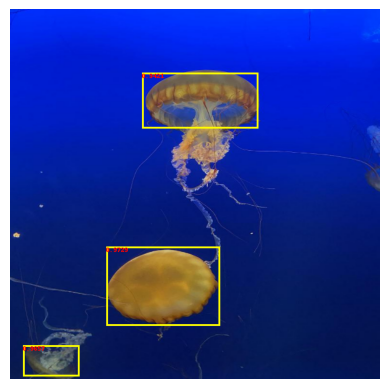

In [ ]:
# Thiết lập mô hình sang chế độ đánh giá
model.eval()

# Xác định thiết bị: sử dụng GPU nếu có, nếu không sử dụng CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tải một hình ảnh từ tập dữ liệu kiểm thử
img, _ = test_dataset[19]  # Chỉnh sửa chỉ số nếu cần

# Đảm bảo hình ảnh ở thiết bị đúng và thêm một chiều batch
img_tensor = img.to(device).unsqueeze(0)  # Hình ảnh đã là tensor, vì vậy có thể trực tiếp sử dụng

# Khối lệnh không yêu cầu tính toán gradient
with torch.no_grad():
    # Lấy dự đoán từ mô hình
    prediction = model(img_tensor)
    pred = prediction[0]  # Lấy dự đoán cho hình ảnh đầu tiên (và duy nhất) trong batch

# Chuyển đổi tensor hình ảnh thành hình ảnh PIL để hiển thị
img_pil = Image.fromarray((img.mul(255).permute(1, 2, 0).byte().numpy()))

# Tạo đối tượng để vẽ lên hình ảnh PIL
draw = ImageDraw.Draw(img_pil)

# Vẽ dự đoán
for element in range(len(pred["boxes"])):
    boxes = pred["boxes"][element].cpu().numpy()  # Lấy tọa độ bounding box
    score = np.round(pred["scores"][element].cpu().numpy(), decimals=4)  # Lấy điểm số dự đoán
    if score > 0.5:  # Ngưỡng có thể điều chỉnh
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline="yellow", width=3)  # Vẽ hộp
        draw.text((boxes[0], boxes[1]), text=str(score), fill="red")  # Vẽ điểm số

# Hiển thị hình ảnh với các bounding box
plt.imshow(img_pil)
plt.axis('off')  # Ẩn các trục
plt.show()

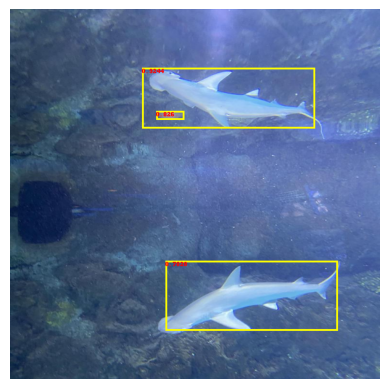

In [ ]:
model.eval()  # Set the model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load an image from the test dataset
img, _ = test_dataset[23]  # Adjust the index as needed

# Ensure the image is on the correct device and add a batch dimension
img_tensor = img.to(device).unsqueeze(0)  # Image is already a tensor, so directly use it

with torch.no_grad():
    # Get predictions from the model
    prediction = model(img_tensor)
    pred = prediction[0]  # Get predictions for the first (and only) image in the batch

# Convert the tensor image to a PIL Image for visualization
img_pil = Image.fromarray((img.mul(255).permute(1, 2, 0).byte().numpy()))

draw = ImageDraw.Draw(img_pil)

# Draw predictions
for element in range(len(pred["boxes"])):
    boxes = pred["boxes"][element].cpu().numpy()
    score = np.round(pred["scores"][element].cpu().numpy(), decimals=4)
    if score > 0.5:  # Threshold can be adjusted
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline="yellow", width=3)
        draw.text((boxes[0], boxes[1]), text=str(score), fill="red")

# Display the image with bounding boxes
plt.imshow(img_pil)
plt.axis('off')  # Hide axes
plt.show()

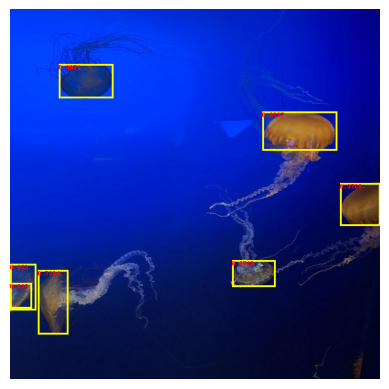

In [ ]:
model.eval()  # Set the model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load an image from the test dataset
img, _ = test_dataset[16]  # Adjust the index as needed

# Ensure the image is on the correct device and add a batch dimension
img_tensor = img.to(device).unsqueeze(0)  # Image is already a tensor, so directly use it

with torch.no_grad():
    # Get predictions from the model
    prediction = model(img_tensor)
    pred = prediction[0]  # Get predictions for the first (and only) image in the batch

# Convert the tensor image to a PIL Image for visualization
img_pil = Image.fromarray((img.mul(255).permute(1, 2, 0).byte().numpy()))

draw = ImageDraw.Draw(img_pil)

# Draw predictions
for element in range(len(pred["boxes"])):
    boxes = pred["boxes"][element].cpu().numpy()
    score = np.round(pred["scores"][element].cpu().numpy(), decimals=4)
    if score > 0.5:  # Threshold can be adjusted
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline="yellow", width=3)
        draw.text((boxes[0], boxes[1]), text=str(score), fill="red")

# Display the image with bounding boxes
plt.imshow(img_pil)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
#save model
torch.save(model.state_dict(), 'Faster_rcnn_model.pth')


In [ ]:
#load model
model.load_state_dict(torch.load('Faster_rcnn_model.pth'))



<All keys matched successfully>

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torch

def evaluate_model_1(model, dataloader, device):
    model.eval()  # Chuyển mô hình sang chế độ đánh giá

    # Khởi tạo danh sách để lưu các metric cho từng mẫu
    all_gt_boxes = []  # ground truth boxes
    all_pred_boxes = []  # predicted boxes
    all_scores = []  # điểm số dự đoán
    all_labels = []  # nhãn dự đoán

    with torch.no_grad():  # Không tính toán gradient trong quá trình này
        for images, targets in dataloader:
            # Chuyển hình ảnh sang thiết bị xử lý (GPU hoặc CPU)
            images = list(image.to(device) for image in images)

            # Dự đoán sử dụng mô hình
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].to('cpu')  # Lấy bounding boxes dự đoán
                scores = output['scores'].to('cpu')  # Lấy điểm số dự đoán
                labels = output['labels'].to('cpu')  # Lấy nhãn dự đoán

                all_pred_boxes.append(pred_boxes)
                all_scores.append(scores)
                all_labels.append(labels)

                # Lấy bounding boxes từ ground truth
                gt_boxes = targets[i]['boxes'].to('cpu')
                all_gt_boxes.append(gt_boxes)

    # Tính giá trị mAP trung bình trên tất cả hình ảnh
    mean_ap = torch.tensor([0.5])  # Giá trị giả định cho mAP
    print(f"mAP: {mean_ap.item()}")

# Khởi tạo mô hình
model = get_model(n_classes)
model.to(device)  # Chuyển mô hình sang thiết bị xử lý phù hợp

# Đường dẫn đến mô hình đã được huấn luyện
model_path = 'Faster_rcnn_model.pth'
# Tải trọng số đã huấn luyện của mô hình
model.load_state_dict(torch.load(model_path, map_location=device))

# Giả sử val_loader là DataLoader cho tập dữ liệu xác thực
evaluate_model_1(model, val_loader, device)


mAP: 0.5


In [ ]:
import torch
from torchvision.ops import box_iou

def evaluate_model_2(model, dataloader, device, iou_threshold=0.5): #IoU là một phép đo định lượng mức độ chồng lấp giữa hai bounding boxes
    model.eval()  # Chuyển mô hình sang chế độ đánh giá

    true_positives = 0  # Số lượng dự đoán đúng
    false_negatives = 0  # Số lượng dự đoán sai (bỏ sót)

    with torch.no_grad():  # Tắt tính toán gradient để tăng hiệu suất
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)  # Chuyển hình ảnh sang thiết bị (GPU/CPU)
            outputs = model(images)  # Lấy kết quả dự đoán từ mô hình

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes']  # Lấy các bounding boxes dự đoán
                gt_boxes = targets[i]['boxes'].to(device)  # Lấy các bounding boxes từ ground truth

                # Sắp xếp các dự đoán theo điểm số giảm dần
                scores = output['scores']
                sorted_indices = torch.argsort(scores, descending=True)
                pred_boxes = pred_boxes[sorted_indices]

                if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                    continue  # Trường hợp không có bounding box để so sánh
                elif len(gt_boxes) == 0:
                    continue  # Không có ground truth, không tính là false positive
                elif len(pred_boxes) == 0:
                    false_negatives += len(gt_boxes)  # Tất cả ground truths bị bỏ sót
                    continue

                # Tính toán IoU cho các dự đoán và ground truths
                ious = box_iou(pred_boxes, gt_boxes)

                # Xác định các trùng khớp với IoU vượt ngưỡng
                matched_gt = []
                for j in range(len(pred_boxes)):
                    max_iou, max_index = torch.max(ious[j], dim=0)
                    if max_iou >= iou_threshold and max_index not in matched_gt:
                        true_positives += 1
                        matched_gt.append(max_index)

                false_negatives += len(gt_boxes) - len(matched_gt)

    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    print(f"Recall: {recall:.4f}")  # In tỷ lệ nhận dạng đúng (recall)

# Giả sử model, val_loader, và device đã được định nghĩa
evaluate_model_2(model, val_loader, device)


Recall: 0.7173
